# Example for fixing intensity attenuation through depth

This Jupyter notebook demonstrates the step-by-step process of fixing the intensity attenuation in a 3D volume, as the imaging level goes deeper. All the essential functions from the `FixImage3D` class are defined here. The sample data used for this demonstration is "SampleData_AFM010_cropped.h5."

*This notebook focuses on stripefix only. For both stripefix and depthfix, please follow the quick run guide provided in the readme file.*

In [6]:
# Import python library
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from skimage import exposure

**Defining Helper Functions**

`calculate_rescale_lim(img_8x,shape)`

This function calculates the 2% minimum (p2) and 98% maximum (p98) values, along with the global maximum, for the 3D image interpolated from the 8x downsampled volume.

`Interpl_8x`

This function nterpolate the given metric array to match the shape of the specified resolution data.


`contrast_fix(img, p2, p98, global_max)`

This function rescales the pixel intensities in a 2D level to enhance contrast and ensure they fall within a specified range.

In [91]:
def calculate_rescale_lim(img_8x, shape):
    """
    Calculate the p2 and p98, min, and mean for the 8x downsampled 3D image.

    Args:
    - img_8x (np.ndarray): The 8x downsampled volume.
    - shape (tuple) : shape of selected res volume.

    Returns:
    - p2 (np.ndarray): Array of 2% min for the highest resolution volume interpolated from 8x downsampled volume.
    - p98 (np.ndarray): Array of 98% max for the highest resolution volume interpolated from 8x downsampled volume.
    - global_max (float): The max intensity for the 3D volume.
    """
    # img_8x = exposure.adjust_gamma(img_8x, 0.7)
    
    p2, p98 = np.percentile(img_8x,
                            (2, 98.5), 
                            axis = (1,2)
                            )
    p2[-1] = p2[-2]
    p98[-1] = p98[-2]
    global_max = p98.max()*0.98

    p2 = Interpl_8x(p2, shape)
    p98 = Interpl_8x(p98, shape)

    return p2, p98, global_max,

def Interpl_8x(metric_array_8x, shape):
    """
    Interpolate to the shape of specified resolution data.

    Args:
    - metric_array_8x (np.ndarray): The metric array of 8x downsampled data.

    Returns:
    - metric (np.ndarray): The interpolated metric array.
    """

    img_length = shape[0]
    n = len(metric_array_8x)
    x = np.linspace(1,n,n)
    xvals = np.linspace(1,n,img_length)
    metric = np.interp(xvals, x, metric_array_8x)

    return metric

def contrast_fix(img, p2, p98, global_max):
    """
    Rescale the p2 and p98 in the 2D image to the out_range.

    Args:
    - img (np.ndarray): The 2D image for the layer of interest.
    - p2 (float):
    - p98 (float):
    - global_max (float):
    - i (int): Index for current layer.

    Returns:
    - img_rescale (np.ndarray): The rescaled 2D image for that layer.
    """

    # img = exposure.adjust_gamma(img, 0.7)
    img_rescale = exposure.rescale_intensity(img, 
                                            in_range=(p2, p98*1.15), 
                                            out_range = (0, global_max)
                                            )
    
    return img_rescale

**Loading and Processing the Data**

In [101]:
h5path = "SampleData_AFM010_cropped.h5"
chan = "s01" # Cyto channel
res = "0"

print("reading 8x downsampled .h5 file...")

with h5.File(h5path, 'r') as f:
    img8x = f['t00000'][chan]["2"]['cells'][:,:,:].astype(np.uint16)
    img = f['t00000'][chan][res]['cells'][:,:,:].astype(np.uint16)
    shape = img.shape
f.close()

p2, p98, global_max = calculate_rescale_lim(img8x, shape)

img_corrected = np.zeros_like(img)
print("converting..")
for i in range(len(img)):
    img_corrected[i] = contrast_fix(img[i], p2[i], p98[i], global_max)

reading 8x downsampled .h5 file...
converting..


**Visualizing the Results**

View the surface level of the volume, compared with deeper level with and without depth attenuation correction. 

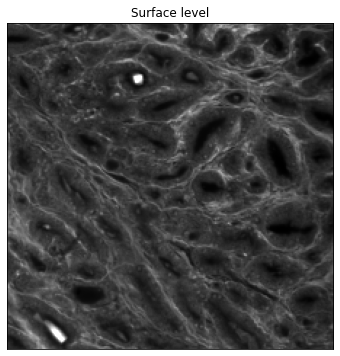

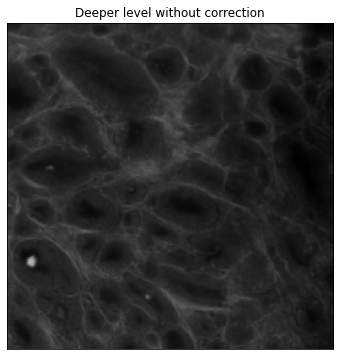

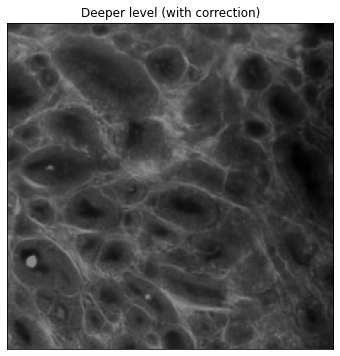

In [104]:
def view_slice(volume, index=0, figsize=(6, 6), vmax = 3000, title = ""):
    """
    Method for viewing 3D images in a jupyter notebook

    Params: 
    - volume : 3D or 2D numpy array
    - index(int) : which level to display, defaults to zero

    """
    fig, ax = plt.subplots(figsize=figsize)
    plt.tick_params(axis='both', which='both', top=False,
                    bottom=False, left=False, right=False,
                    labelbottom=False, labelleft=False)
    ax.volume = volume
    ax.index = index
    ax.set_title(title)
    ax.imshow(volume[ax.index], cmap="gray", vmax=vmax)
    
view_slice(img, 1, vmax=3500, title= "Surface level")
view_slice(img, 180, vmax=3500, title= "Deeper level without correction")
view_slice(img_corrected, 180, vmax=3500, title= "Deeper level (with correction)")